<a href="https://colab.research.google.com/github/Myrto-Iglezou/AI2-project3/blob/master/Question-1-skip-connections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YΣ19 Artificial Intelligence II
# Homework 3

### Iglezou Myrto - 111520170038

# Question 1 - skip connections

In [1]:
import pandas as pd 
from pandas import DataFrame, read_csv

Download the dataset.

In [2]:
import gdown
url = 'https://drive.google.com/file/d/1dTIWNpjlrnTQBIQtaGOh0jCRYZiAQO79/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
output = "twitterData.csv"
gdown.download(path, output, quiet=True)
twitterData = pd.read_csv("/content/twitterData.csv",nrows=20000)
df = pd.DataFrame(data=twitterData)
df.head(5)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


Creating a new dataframe with only two columns, target and text.


In [3]:
df.drop(df.columns.difference(['text','target']), 1, inplace=True)
df['target'].replace({4: 1}, inplace = True)
df.head(5)

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,1,A @ 415 B @ 425. Tell your bro i say congrats!
3,1,@littlefluffycat Indeed.
4,1,Completed Race 4 Life in 58mins with girlies f...


## Data pre-processing

### Removing the scpecial characters

In [4]:
import re

def RemoveSpecialCharacters(x):
    x = re.sub(r'[^\w]+', " ", x)
    return x

In [5]:
df['text'] = df['text'].apply(lambda x: RemoveSpecialCharacters(x) )

### Lemmatize

In [6]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

df['text'] = df['text'].apply(lambda x: WordNetLemmatizer().lemmatize(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Removing the upercase

In [7]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [8]:
df.head(5)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,completed race 4 life in 58mins with girlies f...


## Word embedding - GloVe
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [9]:
from torchtext.vocab import GloVe
glove = GloVe(name='twitter.27B', dim=25)

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:40, 2.17MB/s]                            
100%|█████████▉| 1189878/1193514 [00:26<00:00, 49147.39it/s]

In [25]:
from torchtext.data import Field
text_field = Field(sequential=True,tokenize='spacy',fix_length=100)

label_field = Field(sequential=False, use_vocab=False)
preprocessed_text = df['text'].apply(lambda x: text_field.preprocess(x)) #apply preprocess manually
text_field.build_vocab(preprocessed_text, vectors=glove)  # load embedding with 25d
vocab = text_field.vocab  # get the vocab instance

### Create the datasets

We have train, validation and test datasets that contain text and label information. Train has 80%, validation 10% and test 10%.

In [26]:
from torchtext.data import Dataset, Example
fields = (('target', label_field),('text', text_field))
train_dataset, valid_dataset, test_dataset= Dataset(examples=[Example.fromlist(list(r), fields)
                                               for i, r in df.iterrows()],
                                               fields = fields).split(split_ratio = [0.8, 0.1, 0.1])

## Batching sentences together 
Use *BucketIterator* to create the batches for the 3 datasets with batch size 64.

In [27]:
from torchtext.data import BucketIterator
train_iter, valid_iter, test_iter = BucketIterator.splits(datasets=(train_dataset, valid_dataset, test_dataset),
                                                          batch_sizes=(64,64,64), sort=False)

## Training on GPU

In [28]:
import torch
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


## Architecture of RNN

In [29]:
import torch.nn as nn
import numpy as np
from numpy import zeros

In [30]:
class GRUmodel_a(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using pytorch api. 
    The output is fed to a FFN for classification.
    """
    def __init__(self,embedding, cell_type, input_size, output_size,embedding_dim = 25, \
                 hidden_size=100, num_layers=1, bidirectional=False, dropout = 0):
        super(GRUmodel_a, self).__init__()
        

        # Initializations
        self.embedding = embedding
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        # self.cell_type = cell_type
        self.input_size, self.hidden_size, self.num_layers, self.output_size = embedding_dim, hidden_size, num_layers, output_size
        self.bidirectional = bidirectional
        self.sigmoid = nn.Sigmoid()
       
        self.iL1= self.input_size
        self.oL1= self.hidden_size
        self.iL2= self.oL1*2 
        self.oL2= self.hidden_size
        self.iL3= self.oL2*2
        self.oL3= self.hidden_size

        self.gru1 = nn.GRU(self.iL1,self.oL1, batch_first=True, bidirectional= self.bidirectional)
        self.gru2 = nn.GRU(self.iL2,self.oL2, batch_first=True, bidirectional = self.bidirectional)
        self.gru3 = nn.GRU(self.iL3,self.oL3, batch_first=True, bidirectional = self.bidirectional)
            
        if bidirectional: # we'll have 2 more layers as the output to the final layer
          self.out = nn.Linear(hidden_size * 2, output_size)
        else:
          self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, prints=False):

        x = self.embedding[x]
        outputs = []

        output1, h_n1 = self.gru1(x.detach())
        outputs.append(output1)

        output2, h_n2 = self.gru2(output1)
        outputs.append(output2)

        output3, h_n3 = self.gru3(output2)
        outputs.append(output3)

        r_out = torch.cat(outputs,dim=1)
        
        r_out = r_out[:, -1, :]

        out = self.out(r_out)

        out = self.dropout(out)

        return self.sigmoid(out)

In [31]:
class GRUmodel_b(nn.Module):
    """
    Wrapper module for RNN, LSTM, GRU cells using pytorch api. 
    The output is fed to a FFN for classification.
    """
    def __init__(self,embedding, cell_type, input_size, output_size,embedding_dim = 25, \
                 hidden_size=100, num_layers=1, bidirectional=False, dropout = 0):
        super(GRUmodel_b, self).__init__()
        

        # Initializations
        self.embedding = embedding
        # dropout layer
        self.dropout = nn.Dropout(dropout)
        # self.cell_type = cell_type
        self.input_size, self.hidden_size, self.num_layers, self.output_size = embedding_dim, hidden_size, num_layers, output_size
        self.bidirectional = bidirectional
        self.sigmoid = nn.Sigmoid()
       
        self.iL1= self.input_size
        self.oL1= self.hidden_size
        self.iL2= self.oL1*2 
        self.oL2= self.hidden_size

        self.gru1 = nn.GRU(self.iL1,self.oL1, batch_first=True, bidirectional= self.bidirectional)
        self.gru2 = nn.GRU(self.iL2,self.oL2, batch_first=True, bidirectional = self.bidirectional)
            
        if bidirectional: # we'll have 2 more layers as the output to the final layer
          self.out = nn.Linear(hidden_size * 2, output_size)
        else:
          self.out = nn.Linear(hidden_size, output_size)
          
    def forward(self, x, prints=False):

        x = self.embedding[x]
        outputs = []

        output1, h_n1 = self.gru1(x.detach())
        outputs.append(output1)

        output2, h_n2 = self.gru2(output1)
        outputs.append(output2)

        r_out = torch.cat(outputs,dim=1)
        
        r_out = r_out[:, -1, :]

        out = self.out(r_out)

        out = self.dropout(out)

        return self.sigmoid(out)

In [32]:
def train(model,X,y,optimizer,loss_fn):

  if train_on_gpu:
    X, y = X.cuda(), y.cuda()

  # step 1. Zero the gradients
  optimizer.zero_grad()
  # step 2. Compute the output
  y_pred = model(X)

  if train_on_gpu:
    y_pred = y_pred.squeeze().cuda()
  else:
    y_pred = y_pred.squeeze()
  # step 3. Compute the loss
  loss = loss_fn(y_pred, y)
  # step 4. use loss to produce gradients
  loss.backward()
  # step 5. use optimizer to take gradient step
  optimizer.step()

  return loss.item(),y_pred

In [33]:
def validate(classifier,X,y,loss_fn):
  y_pred =  classifier(X)

  if train_on_gpu:
    y_pred = y_pred.squeeze().cuda()
  else:
    y_pred = y_pred.squeeze()

  loss = loss_fn(y_pred, y)

  return loss.item(),y_pred


In [34]:
def predict(model,X):
    outputs = model(X)
    return torch.round(outputs)

# Functions for training and testing net



In [35]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score

def trainNet(net,train_iter,valid_iter,num_epochs,clip_param):
  # move model to GPU, if available
  if train_on_gpu:
      net.cuda()

  # Accumulate losses
  train_losses = []
  valid_losses = []
  epoch_train_losses = []
  epoch_valid_losses = []

  train_accuracy = []
  valid_accuracy = []

  for epoch in range(num_epochs):

      #change to train mode
      net.train() 

      train_accuracy = []
      valid_accuracy = []

      epoch_train_losses = []
      epoch_valid_losses = []
      for batch in train_iter:

        loss, pred = train(net, batch.text.T, batch.target.float(), optimizer, loss_function)
        epoch_train_losses.append(loss)
        
        pred = torch.round(pred)
        pred = pred.detach().numpy()
        test = batch.target.float()
        test = test.numpy()

        train_accuracy.append(accuracy_score(test, pred))

        #Clip gradients
        for param in net.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -clip_param, clip_param)
      
      # change to evaluation mode
      net.eval()

      for step,batch in enumerate(valid_iter):
          with torch.no_grad():
            # Faster inference
              if(train_on_gpu):
                    inputs, labels = batch.text.cuda(), batch.target.float().cuda()
              else:
                inputs, labels = batch.text, batch.target.float()
              
              loss, pred = validate(net, inputs.T, labels,loss_function)
              epoch_valid_losses.append(loss)

              pred = torch.round(pred)
              pred = pred.detach().numpy()
              valid = labels
              valid = valid.numpy()

              valid_accuracy.append(accuracy_score(valid, pred))
              # print(f'Epoch: {epoch}| Validation CE loss: {loss:4f} | Test accuracy: {100 * valid_accuracy[-1]:.2f} %')

      print(f'Epoch: {epoch}|| Train accuracy: {100 * np.mean(train_accuracy):.2f} | Valid accuracy: {100 * np.mean(valid_accuracy):.2f} %')
      
      train_losses.append(np.mean(epoch_train_losses))
      valid_losses.append(np.mean(epoch_valid_losses))

  return train_losses,valid_losses



In [36]:
import matplotlib.pyplot as plt

def lossVSepoch(valid_losses,train_losses):

    plt.figure(figsize=(8,5))

    plt.plot(valid_losses,'o-',color="r")

    plt.plot(train_losses,'o-',color="g")

    plt.grid()

    plt.plot(valid_losses, 'o-', color="r",
                    label="Validation loss")
    plt.plot(train_losses,  'o-', color="g",
                    label="Training loss")

    plt.legend(loc="best")

    plt.xlabel("epochs")
    plt.ylabel("losses")
    plt.title("Scalability of the model")

    plt.show()

In [37]:
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score
from sklearn.metrics import classification_report

def testNet(net, test_iter):

  accuracy = []
  f1 = []
  recall = []
  precision = []
  report = []

  for batch in test_iter:
        
      y_pred = predict(net,batch.text.T)
      y_pred = y_pred.detach().numpy()
      y_test = batch.target.float()
      y_test = y_test.numpy()

      acc = accuracy_score(y_test, y_pred)
      f1_sc = f1_score(y_test, y_pred, average='macro',labels=np.unique(y_pred))
      rec = recall_score(y_test, y_pred, average='macro')
      prec = precision_score(y_test, y_pred, average='macro',labels=np.unique(y_pred))
      
      accuracy.append(acc)
      f1.append(f1_sc)
      recall.append(rec)
      precision.append(prec)
      

      report.append(classification_report(y_test, y_pred))
  print('\n------------------- Scores ----------------------\n')
  print(f'Accuracy: {100 * np.mean(accuracy):.2f} %')
  print(f'F1-score: {100 * np.mean(f1):.2f} %')
  print(f'Recall-score: {100 * np.mean(recall):.2f} %')
  print(f'Precision: {100 * np.mean(precision):.2f} %')
  
  return np.mean(accuracy),np.mean(f1),np.mean(recall),np.mean(precision)

## Create dataframe to keep all experiments

In [38]:
FinalDf = pd.DataFrame(columns=[['Cell type','Epochs','Layers of stacked RNNs','Hidden size of layers','Skip connections',\
                                 'gradient clipping','Dropout prob','Accuracy','F1-score','Recall-score','Precision']])

## Neural Network - **GRU**


GRU model with skip connections
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 54.12 | Valid accuracy: 59.38 %
Epoch: 1|| Train accuracy: 57.00 | Valid accuracy: 53.76 %
Epoch: 2|| Train accuracy: 58.98 | Valid accuracy: 67.33 %
Epoch: 3|| Train accuracy: 59.94 | Valid accuracy: 67.63 %

------------------- Scores ----------------------

Accuracy: 68.12 %
F1-score: 67.67 %
Recall-score: 68.02 %
Precision: 67.95 %

------------- Loss vs Epochs plot ---------------



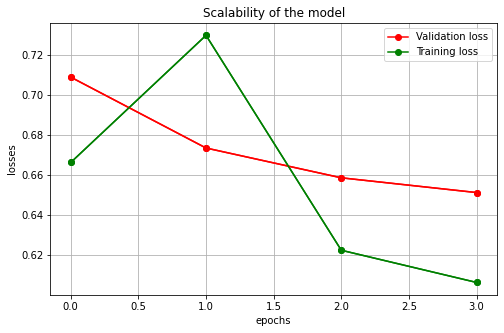

In [39]:
# ============
input_size = 100       # length is 100, given in Field
output_size = 1     
bidirectional = True
cell_type = 'GRU'
embedding_dim = 25
# =============================
hidden_size = 256     # number of hidden neurons
num_layers =  1        # number of layers
dropout = 0.3
clip_param = 5
# =============================
num_epochs = 4
LR = 0.01
loss_function = nn.BCELoss()
# ==============================


net = GRUmodel_a(vocab.vectors,cell_type, input_size, output_size,embedding_dim, hidden_size, num_layers, bidirectional,dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters

print(f"\nGRU model with skip connections")
print("-----------------------------------------------------------------\n")
valid_losses,train_losses = trainNet(net,train_iter,valid_iter,num_epochs,clip_param)
acc, f1,recall,precision = testNet(net, test_iter)
FinalDf.loc[len(FinalDf)] = [cell_type,num_epochs,num_layers,hidden_size,'3 layers',clip_param,dropout,acc,f1,recall,precision]
print("\n------------- Loss vs Epochs plot ---------------\n")
lossVSepoch(valid_losses,train_losses)


In [40]:
FinalDf

,Cell type,Epochs,Layers of stacked RNNs,Hidden size of layers,Skip connections,gradient clipping,Dropout prob,Accuracy,F1-score,Recall-score,Precision
0,GRU,4,1,256,3 layers,5,0.3,0.681152,0.676686,0.680191,0.679492



GRU model with skip connections
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 51.73 | Valid accuracy: 49.66 %
Epoch: 1|| Train accuracy: 54.73 | Valid accuracy: 60.55 %
Epoch: 2|| Train accuracy: 60.19 | Valid accuracy: 66.65 %
Epoch: 3|| Train accuracy: 61.86 | Valid accuracy: 66.26 %

------------------- Scores ----------------------

Accuracy: 64.21 %
F1-score: 61.13 %
Recall-score: 64.43 %
Precision: 69.91 %

------------- Loss vs Epochs plot ---------------



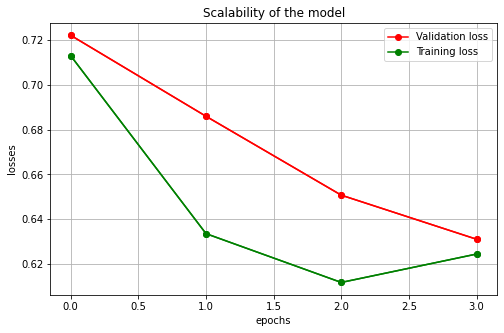

In [41]:
# ============
input_size = 100       # length is 100, given in Field
output_size = 1     
bidirectional = True
cell_type = 'GRU'
embedding_dim = 25
# =============================
hidden_size = 256     # number of hidden neurons
num_layers =  1        # number of layers
dropout = 0.3
clip_param = 3
# =============================
num_epochs = 4
LR = 0.01
loss_function = nn.BCELoss()
# ==============================


net = GRUmodel_b(vocab.vectors,cell_type, input_size, output_size,embedding_dim, hidden_size, num_layers, bidirectional,dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters

print(f"\nGRU model with skip connections")
print("-----------------------------------------------------------------\n")
valid_losses,train_losses = trainNet(net,train_iter,valid_iter,num_epochs,clip_param)
acc, f1,recall,precision = testNet(net, test_iter)
FinalDf.loc[len(FinalDf)] = [cell_type,num_epochs,num_layers,hidden_size,'2 layers',clip_param,dropout,acc,f1,recall,precision]
print("\n------------- Loss vs Epochs plot ---------------\n")
lossVSepoch(valid_losses,train_losses)


In [42]:
FinalDf

,Cell type,Epochs,Layers of stacked RNNs,Hidden size of layers,Skip connections,gradient clipping,Dropout prob,Accuracy,F1-score,Recall-score,Precision
0,GRU,4,1,256,3 layers,5,0.3,0.681152,0.676686,0.680191,0.679492
1,GRU,4,1,256,2 layers,3,0.3,0.642090,0.611291,0.644334,0.699096



GRU model with skip connections
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 51.49 | Valid accuracy: 49.02 %
Epoch: 1|| Train accuracy: 51.47 | Valid accuracy: 50.68 %
Epoch: 2|| Train accuracy: 51.42 | Valid accuracy: 57.13 %

------------------- Scores ----------------------

Accuracy: 55.76 %
F1-score: 53.88 %
Recall-score: 55.78 %
Precision: 56.64 %

------------- Loss vs Epochs plot ---------------



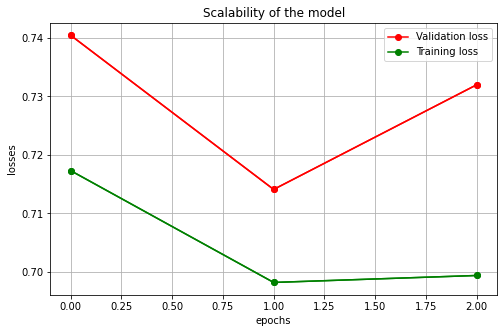

In [43]:
# ============
input_size = 100       # length is 100, given in Field
output_size = 1     
bidirectional = True
cell_type = 'GRU'
embedding_dim = 25
# =============================
hidden_size = 256     # number of hidden neurons
num_layers =  1        # number of layers
dropout = 0.3
clip_param = 3
# =============================
num_epochs = 3
LR = 0.01
loss_function = nn.BCELoss()
# ==============================


net = GRUmodel_a(vocab.vectors,cell_type, input_size, output_size,embedding_dim, hidden_size, num_layers, bidirectional,dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters

print(f"\nGRU model with skip connections")
print("-----------------------------------------------------------------\n")
valid_losses,train_losses = trainNet(net,train_iter,valid_iter,num_epochs,clip_param)
acc, f1,recall,precision = testNet(net, test_iter)
FinalDf.loc[len(FinalDf)] = [cell_type,num_epochs,num_layers,hidden_size,'3 layers',clip_param,dropout,acc,f1,recall,precision]
print("\n------------- Loss vs Epochs plot ---------------\n")
lossVSepoch(valid_losses,train_losses)


In [44]:
FinalDf

,Cell type,Epochs,Layers of stacked RNNs,Hidden size of layers,Skip connections,gradient clipping,Dropout prob,Accuracy,F1-score,Recall-score,Precision
0,GRU,4,1,256,3 layers,5,0.3,0.681152,0.676686,0.680191,0.679492
1,GRU,4,1,256,2 layers,3,0.3,0.642090,0.611291,0.644334,0.699096
2,GRU,3,1,256,3 layers,3,0.3,0.557617,0.538821,0.557849,0.566448



GRU model with skip connections
-----------------------------------------------------------------

Epoch: 0|| Train accuracy: 50.27 | Valid accuracy: 49.71 %
Epoch: 1|| Train accuracy: 53.47 | Valid accuracy: 54.00 %
Epoch: 2|| Train accuracy: 54.84 | Valid accuracy: 58.11 %

------------------- Scores ----------------------

Accuracy: 59.42 %
F1-score: 58.97 %
Recall-score: 59.61 %
Precision: 59.66 %

------------- Loss vs Epochs plot ---------------



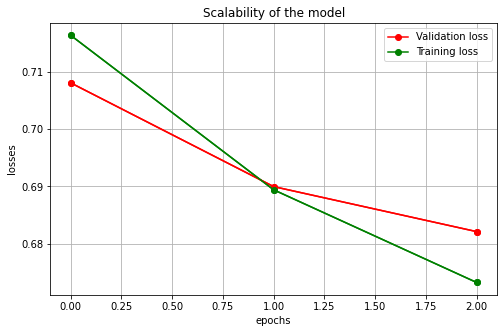

In [45]:
# ============
input_size = 100       # length is 100, given in Field
output_size = 1     
bidirectional = True
cell_type = 'GRU'
embedding_dim = 25
# =============================
hidden_size = 256     # number of hidden neurons
num_layers =  1        # number of layers
dropout = 0.3
clip_param = 3
# =============================
num_epochs = 3
LR = 0.01
loss_function = nn.BCELoss()
# ==============================


net = GRUmodel_b(vocab.vectors,cell_type, input_size, output_size,embedding_dim, hidden_size, num_layers, bidirectional,dropout)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters

print(f"\nGRU model with skip connections")
print("-----------------------------------------------------------------\n")
valid_losses,train_losses = trainNet(net,train_iter,valid_iter,num_epochs,clip_param)
acc, f1,recall,precision = testNet(net, test_iter)
FinalDf.loc[len(FinalDf)] = [cell_type,num_epochs,num_layers,hidden_size,'2 layers',clip_param,dropout,acc,f1,recall,precision]
print("\n------------- Loss vs Epochs plot ---------------\n")
lossVSepoch(valid_losses,train_losses)


In [46]:
FinalDf

,Cell type,Epochs,Layers of stacked RNNs,Hidden size of layers,Skip connections,gradient clipping,Dropout prob,Accuracy,F1-score,Recall-score,Precision
0,GRU,4,1,256,3 layers,5,0.3,0.681152,0.676686,0.680191,0.679492
1,GRU,4,1,256,2 layers,3,0.3,0.642090,0.611291,0.644334,0.699096
2,GRU,3,1,256,3 layers,3,0.3,0.557617,0.538821,0.557849,0.566448
3,GRU,3,1,256,2 layers,3,0.3,0.594238,0.589683,0.596148,0.596578


# **Remarks**



*   For this model we used GloVe for the pre-process, with vector size 25. RMS was chosen as an optimizer and BCELoss as loss function, because of the binary classification.
*   For neural network architecture:

> * The first layer is an Embedding layer, which matches the input vectors to the vocabulary vectors.
> * The second layer is a Linear hidden layer,which accepts as input size, the size of the features multiplied by the size of the GloVe vectors. It uses ReLU as activation function.
>* The output layer is Linear with input dimension  200 and output 1 with sigmoid as activation function.









## References

* https://discuss.pytorch.org/t/how-to-stack-bidirectional-gru-layers-with-different-hidden-size-and-residual-connections/96116?fbclid=IwAR0aHdi2eoe4qx0oyzQnMx7_nilxt6krmGPb5Ko37OX6vYTgOoY9P3i1knk

*   https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f

*   https://d2l.ai/chapter_convolutional-modern/resnet.html

